# Implement a custom Autoencoder with Koopman layer

## Version Control

To Do:
1) Account for trailing batch - Make robust (fixed issue by reshaping input data)
2) Get Koopman operator, K
3) Preprocess Data
4) Make sure sim data is different for different ground parameters
5) Use static Koopman AE to train and get Koopman
6) Validation data has different batch size. Address when HP training
7) Address gradient issue: K^m(g(x)). Loss function does not properly address that gradient most likely

## Setup

In [242]:
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
import  numpy as np
import pandas as pd
import time 
import os

In [243]:
plt.rcParams['figure.figsize'] = [9, 6]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [244]:
#from google.colab import drive
#drive.mount('/gdrive')

Comment out if don't need

In [245]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Data

**Dyanmics of the Simple Pendulum**


![dynamics](\images\dynamics.PNG)


$\lambda = -1$
$\mu = -0.05$

In [246]:
discrete_train = pd.read_csv('data/DiscreteSpectrumExample_train1_x.csv', sep=',', header=None).values
discrete_test =pd.read_csv('data/DiscreteSpectrumExample_test_x.csv', sep=',', header=None).values
discrete_validation = pd.read_csv('data/DiscreteSpectrumExample_val_x.csv', sep=',', header=None).values

In [247]:
trajLength = 64 #length of each trajectory in the dataset
numTraj = 1024 #total number of trajectories in the dataset
batch_size = int(256) # Number of snapshots in each batch

numTraj_batch = int(batch_size/trajLength)
input_dim = 2

num_batches = 128 ## num_batches = trajLength*numTraj/batch_size (max = 128)

In [249]:
# Normalize the data
min_val = tf.reduce_min(discrete_train)
max_val = tf.reduce_max(discrete_train)

discrete_train = (discrete_train - min_val) / (max_val - min_val)
discrete_validation = (discrete_validation - min_val) / (max_val - min_val)
discrete_test = (discrete_test - min_val) / (max_val - min_val)

train_data = tf.cast(discrete_train[0:batch_size*num_batches], tf.float32)
validation_data = tf.cast(discrete_validation[0:batch_size*num_batches], tf.float32)
validation_data = tf.data.Dataset.from_tensor_slices((validation_data, validation_data)).batch(batch_size)
test_data = tf.cast(discrete_test, tf.float32)

## Preprocess data

In [250]:
x_train = train_data
y_train = train_data

tf.shape(x_train)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([32768,     2])>

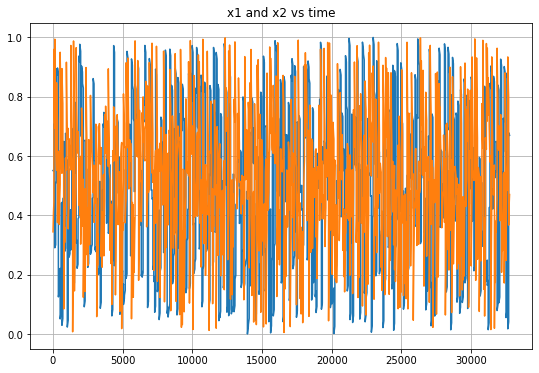

In [251]:
trail = train_data[trajLength*100:trajLength*110,:]
plt.grid()
plt.plot(x_train) #51 samples for each trajectory
plt.title("x1 and x2 vs time")
plt.show()

# Custom Model definition

## Encoder

In [252]:
class EncoderLayer(keras.layers.Layer):
    """
    Custom class to create a encoder layer
    
    Parameters
    ----------
    units: number of units in the layer 
        units are assigned to the layer at the time of initialization
    
    input_shape: shape of the input (output from previous layer)
        input_shape is used to build the weight matrix at the time of call
        
    Return
    ----------
    W.T * x + b: tensor
        linear combination of weights times input + bias for the layer
    """
    
    def __init__(self, units=32, name=None):
        super(EncoderLayer, self).__init__(name=name)
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            name = 'weight',
            shape=(input_shape[-1], self.units),
            initializer="glorot_uniform",
            trainable=True,
        )
        self.b = self.add_weight(
            name = 'bias',
            shape=(self.units,), initializer="zeros", trainable=True
        )
        #print("Encoder Layer, weight dimension:",tf.shape(self.w))

    def call(self, inputs):
        #print("Encoder Layer, output dimension:",tf.shape(tf.matmul(inputs, self.w) + self.b))
        return tf.matmul(inputs, self.w) + self.b

In [253]:
class EncoderModel(keras.Model):
    """
    Custom Model to create an encoder with one input
    
    Parameters
    ----------
    input: tensor 
        x - the the orignal state inputs x given as snapshots taken from random trajectory
    
    Return
    ----------
    z: tensor
        Latent variables of x in the lifted space
    """
    
    def __init__(self, name=None):
        super(EncoderModel, self).__init__(name=name)
        self.enc1 = EncoderLayer(16)
        self.enc2 = EncoderLayer(32)
        self.enc3 = EncoderLayer(64)

    def call(self, input):
        x = input
        x = self.enc1(x)
        x = tf.nn.elu(x)
        x = self.enc2(x)
        x = tf.nn.elu(x)

        # Encoder output layer
        z = self.enc3(x)
        z = tf.nn.elu(z)
        return z

## Koopman

In [361]:
class KoopmanLayer(keras.layers.Layer):
    """
    Custom class to calculate the Koopman operator K on latent variables
    Adds a linear loss as mse(Z2-Z2_tilde)
    
    Parameters
    ----------
    Z: tensor 
        inputs are the latent variabes (output from encoder)
        input dimension is (m, 128)
        m is the number of time snapshots for each input dimension of X
        128 is the number of latent varibales (observables)

    Return
    ----------
    Z: tensor
        return the original input Z 

    Z2_hat: tensor
        return the prediction from K (z2_hat = K*z1)

    Z2_tilde: tensor
        return the prediction by linearity from K (z2_tilde = K^m * z(1,:))
    """

    def __init__(self, trajLength, numTraj):
        super(KoopmanLayer, self).__init__()
        self.trajLength = trajLength
        self.numTraj = numTraj

    def build(self, Z):
        # Initialize K as a weight
            self.K =  self.add_weight(
                name = 'Koopman_weight',
                shape=(Z[-1], Z[-1]),
                initializer="random_normal",
                trainable=True,
            )

    def timeShift(self,Z,latent_dim):
        '''
        Shifts trajectories one time step
        Parameters:
        -----------
            Z: tensor
                Batch data of latent variables (in the lifted space)
                
            latent_dim: tensor shape
                Dimension of the lifted space (columns of Z)
        '''
        Z1 = []
        z1 = []
        Z2 = []

        for i in range(self.numTraj):
            Z1.append(Z[i*self.trajLength:(i+1)*self.trajLength-1,:])
            Z2.append(Z[i*self.trajLength+1:(i+1)*self.trajLength,:])
            z1.append(Z[i*self.trajLength,:])
        return tf.reshape(Z1, [-1, latent_dim]), tf.reshape(Z2, [-1, latent_dim]), tf.reshape(z1, [-1, latent_dim])       

    def call(self, Z):
        latent_dim = tf.shape(Z)[1]
        shift_len = (self.trajLength-1)*self.numTraj # length of rows for forward time shifted Z
        Z1, Z2, z1 = self.timeShift(Z,latent_dim)

        # Find Z2_tilde
        Z2_tilde = tf.zeros([shift_len, latent_dim], dtype=tf.float32)
        for traj in range(self.numTraj): # loop over numnber of traj
            for m in range(self.trajLength-1): #loop over snapshots in each traj
                 #K = tf.zeros([latent_dim, latent_dim], dtype=tf.float32)
                 
                 indices = tf.constant([[traj*(self.trajLength-1)+m]])
                 if m == 0:
                    K = self.K 
                    # Matrix matvec works out to get Kz' and returns as row vector
                    updates = [tf.linalg.matvec(K, z1[traj,:])] #updates the row tensor at index = indices 
                    Z2_tilde = tf.tensor_scatter_nd_update(Z2_tilde, indices, updates)
                 else:
                    K = tf.matmul(K,self.K)
                    updates = [tf.linalg.matvec(K, z1[traj,:])]
                    Z2_tilde = tf.tensor_scatter_nd_update(Z2_tilde, indices, updates)
           
        # Find linear loss
        Linear_loss = tf.reduce_mean(tf.square(tf.subtract(Z2,Z2_tilde)))
        self.add_loss(Linear_loss)
        
        # prints for debugging dimensions
        #print("Koopman layer, K",tf.shape(K))
        #print("Koopman layer, m",tf.shape(m))
        #print("Koopman layer, Z",tf.shape(Z))
        #print("Koopman layer, z1",tf.shape(z1))
        #print("Koopman layer, Z2 ",tf.shape(Z2))
        #print("Koopman layer, Z2_tilde",tf.shape(Z2_tilde))
        
        return Z, tf.matmul(Z1,self.K), Z2_tilde,

In [ ]:
kk = tf.constant([1, 2, 3, 4], shape=[2,2], dtype=tf.float32)
z1 = tf.constant([[1,2,3,4,5,6],[1,2,3,4,5,6]], shape=[6,2], dtype=tf.float32)

sl = 4
ld = 2

nt = 2
tl = 3


Z2_tilde = tf.zeros([sl, ld], dtype=tf.float32)
for traj in range(nt): # loop over numnber of traj
    for m in range(tl-1): #loop over snapshots in each traj
            indices = tf.constant([[traj*(tl-1)+m]])
            print("indices", indices)
            if m == 0: 
                print("m:",m)
                updates = [tf.linalg.matvec(kk, z1[traj,:])] #updates the row tensor at index = indices 
                Z2_tilde = tf.tensor_scatter_nd_update(Z2_tilde, indices, updates)
                print(Z2_tilde)

            else:
                print("m:",m)
                updates = [tf.linalg.matvec(tf.matmul(kk,kk), z1[traj,:])]
                Z2_tilde = tf.tensor_scatter_nd_update(Z2_tilde, indices, updates)
                print(Z2_tilde)

In [362]:
class Koopman_Model(keras.Model):
    """
    Custom Model to create an encoder with koopman layer
    
    Parameters
    ----------
    input: tensor 
        z - the the orignal state inputs x given as snapshots taken from random trajectory
    
    Return
    ----------
    z: tensor
        Latent variables of x in the lifted space
    
    Z2_hat: tensor
        return the prediction from K (z2_hat = K*z1)

    z2_tilde: tensor
        Latent variables of prediction obtained by linearity from K (z2_tilde = K^m * z(1,:))
        
    """
    
    def __init__(self, trajLength, numTraj , name=None):
        super(Koopman_Model, self).__init__(name=name)
        self.koopman = KoopmanLayer(trajLength,numTraj)


    def call(self, input):
        z = input
        z, Z2_hat, z2_tilde = self.koopman(z)
        return z, Z2_hat, z2_tilde

## Decoder

In [363]:
class DecoderLayer(keras.layers.Layer):
    """
    Custom class to create a decoder layer with two inputs
    
    Parameters
    ----------
    units: number of units in the layer 
        units are assigned to the layer at the time of initialization
    
    input_shape: shape of the input (output from previous layer)
        input_shape is used to build the weight matrix at the time of call
        
    Return
    ----------
    W.T * input1 + b: tensor
        linear combination of weights times input1 + bias for the layer
        
    W.T * input2 + b: tensor
        linear combination of weights times input2 + bias for the layer

    W.T * input3 + b: tensor
        linear combination of weights times input3 + bias for the layer
    """

    def __init__(self, units=32, name=None):
        super(DecoderLayer, self).__init__(name=name)
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            name = 'weight',
            shape=(input_shape[-1], self.units),
            initializer="glorot_uniform",
            trainable=True,
        )
        self.b = self.add_weight(
            name = 'bias',
            shape=(self.units,), initializer="zeros", trainable=True
        )
        #print("Decoder Layer, weight dimension:",tf.shape(self.w))

    def call(self, input1, input2, input3):
        #print("Decoder Layer, output dimension:",tf.shape(tf.matmul(inputs, self.w) + self.b))
        return tf.matmul(input1, self.w) + self.b, tf.matmul(input2, self.w) + self.b, tf.matmul(input3, self.w) + self.b

In [364]:
class DecoderModel(keras.Model):
    """
    Custom Model to create a decoder with two inputs
    
    Parameters
    ----------
    input 1: tensor 
        z - the lifted output of the koopman layer (encoder output)
    
    input 2: tensor 
        z2_tilde - obtained by linearity from K (z2_tilde = K^m * z(1,:))
        
    Return
    ----------
    x_hat: tensor
        Reconstuction of the orignal state inputs x (label values are x)
    
    x2_hat: tensor
        Prediction of the original state inputs x (label values are forward time shifted x)

    x2_tilde: tensor
        Prediction obtained by linearity from K 
    
    """
    
    def __init__(self, name=None):
        super(DecoderModel, self).__init__(name=name)
        self.dec1 = DecoderLayer(32)
        self.dec2 = DecoderLayer(16)
        self.outputLayer = DecoderLayer(2)

    def call(self, input1, input2, input3):
        z = input1
        z2_hat = input2
        z2_tilde = input3

        z, z2_hat, z2_tilde = self.dec1(z, z2_hat, z2_tilde)
        z = tf.nn.elu(z)
        z2_hat = tf.nn.elu(z2_hat)
        z2_tilde = tf.nn.elu(z2_tilde)

        z, z2_hat, z2_tilde = self.dec2(z, z2_hat, z2_tilde)
        z = tf.nn.elu(z)
        z2_hat = tf.nn.elu(z2_hat)
        z2_tilde = tf.nn.elu(z2_tilde)

        # Decoder output layer
        x_hat, x2_hat, x2_tilde = self.outputLayer(z, z2_hat, z2_tilde)
        x_hat = tf.nn.elu(x_hat)
        x2_hat = tf.nn.elu(x2_hat)
        x2_tilde = tf.nn.elu(x2_tilde)

        return x_hat, x2_hat, x2_tilde

## Koopman Autoencoder

In [365]:
class Koopman_AE_Model(keras.Model):
    """
    Custom Model to create a Koopman Autoencoder
    
    Parameters
    ----------
    input: tensor 
        x - the the orignal state inputs x given as snapshots taken from random trajectory
    
    Return
    ----------
    x_hat: tensor
        Reconstuction of the orignal state inputs x (label values are x)
    
    x2_hat: tensor
        Predcition of the original state inputs x (label values are forward time shifted x)
    
    x2_tilde: tensor
        Prediction obtained by linearity from K 
    """
    
    def __init__(self, trajLength, numTraj , name=None):
        super(Koopman_AE_Model, self).__init__(name=name)
        self.enc = EncoderModel()
        self.koopman = Koopman_Model(trajLength, numTraj)
        self.dec = DecoderModel()

    def call(self, input):
        x = input
        z = self.enc(x)
        z, z2_hat, z2_tilde = self.koopman(z)
        x_hat, x2_hat, x2_tilde = self.dec(z, z2_hat, z2_tilde)
        return x_hat, x2_hat, x2_tilde

# Custom Training Loop

In [366]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_data))
train_dataset = train_dataset.batch(batch_size)

In [368]:
class MyStaticModel():
    def __init__(self, input_dim, batch_size, trajLength):
        # Initialize constants
        self.batch_size = batch_size
        self.trajLength = int(trajLength) #should be int
        self.numtraj_batch = int(self.batch_size/self.trajLength) # should be int
        self.inputs = tf.keras.layers.Input(shape=(input_dim,))
        self.graphCounter = 0 

    ######################################  LOSS FUNCTIONS  ###################################################
    def tot_loss(self, model, x, x_hat, x2_hat, x2_tilde):
        """Calculates total loss as sum of recon_loss + predict_loss + Koopman_loss"""
        #alpha1 = 0.1, alpha2 = 1e-7, alpha3 = 1e-15
        alpha1 = 1
        alpha2 = 1e-5
        alpha3 = 1e-10

        x2 = []
        for i in range(self.numtraj_batch):
            x2.append(x[i*self.trajLength+1:(i+1)*self.trajLength])
        x2 = tf.reshape(x2, [-1, x.shape[-1]])

        recon_loss = tf.reduce_mean(tf.square(tf.subtract(x,x_hat)))
        predict_loss =tf.reduce_mean(tf.square(tf.subtract(x2,x2_tilde)))

        weights  = model.trainable_variables
        lossL2 = tf.add_n([tf.nn.l2_loss(w) for w in weights if 'bias' not in w.name])

        Linf_loss = tf.add(tf.norm(tf.subtract(x,x_hat), ord=np.inf), tf.norm(tf.subtract(x2,x2_hat), ord=np.inf))
        return alpha1*(recon_loss+predict_loss) + alpha2*Linf_loss + alpha3*lossL2 + sum(model.losses)

    ###############################################  GRAPH FUNCTIONS     #########################################################

    def graphPlot(self, error, error_val):
        saveFiles = True
        imgPath = 'graphs/'
        if saveFiles:
            try:
                os.mkdir(imgPath)
            except:
                print("Tried making folder. Folder already exists...")
        
        plt.figure(figsize=(10,10))
        plt.xlabel('time', fontsize=16)
        plt.ylabel('x', fontsize=16)
        plt.plot(error, label="Training Loss")
        plt.plot(error_val, label = "Validation Loss")
        textTitle = "All Epoch Loss %d" % self.graphCounter
        self.graphCounter += 1
        plt.title(textTitle)
        plt.legend()
        if saveFiles:
            plt.savefig(imgPath+textTitle+'.png', bbox_inches='tight') 
        plt.close()

    
    def graphBatchLossPlot(self, epochNum, error, error_val):
        saveFiles = True
        imgPath = 'graphs/'
        if saveFiles:
            try:
                os.mkdir(imgPath)
            except:
                print("Tried making folder. Folder already exists...")
        
        plt.figure(figsize=(10,10))
        plt.xlabel('time', fontsize=16)
        plt.ylabel('x', fontsize=16)
        plt.plot(error, label="Batch Training Loss")
        plt.plot(error_val, label="Batch Validation Loss")
        textTitle = "BatchLoss_%d_Epoch_%d" % (epochNum, self.graphCounter)
        plt.title(textTitle)
        plt.legend()
        if saveFiles:
            plt.savefig(imgPath+textTitle+'.png', bbox_inches='tight')
        plt.close() 

    ###############################################     FIT FUNCTION        #########################################################

    def fit(self, model, x, y, validation_data, batch_size):
        # Preprocess data
        train_ds = tf.data.Dataset.from_tensor_slices((x, y)).batch(batch_size)

        # Define the optimizer
        optimizer = tf.keras.optimizers.Adam(1e-4)

        epochs = 5      
        
        epoch_train_loss = [] # total loss for each epoch
        epoch_validation_loss = []

        for epoch in range(epochs):

            print("\nStart of epoch %d" % (epoch,))
            start_time = time.time()

            batch_train_loss_list = [] # total loss for each batch 
            batch_validation_loss_list = []

            # Iterate over the train batches of the dataset.
            for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
                batch_train_loss = 0
                with tf.GradientTape() as tape:
                    reconstruction, prediction, linearity = model(x_batch_train)

                    # total avg loss for each batch
                    batch_train_loss = self.tot_loss(model, y_batch_train, reconstruction, prediction, linearity)
                    batch_train_loss_list.append(batch_train_loss)

                grads = tape.gradient(batch_train_loss, model.trainable_variables)
                optimizer.apply_gradients(zip(grads, model.trainable_variables))
                    
                # Log every 100 batches.
                
                #if step % 100 == 0:
                #    print(
                #        "Training loss (for one batch) at step %d: %.4f"
                #        % (step, float(batch_train_loss))
                #    )
                
            
            # outside batch loop
            avg_train_loss = np.sum(batch_train_loss_list)/num_batches
            epoch_train_loss.append(avg_train_loss)

            print("Average training loss at epoch %d: %.4f"% (epoch, float(avg_train_loss)))
            #print("Time taken: %.2fs" % (time.time() - start_time))
            #print("Sum of Koopman Layer weights: %0.3f" % np.sum(model.koopman.get_weights()[0]))
        
            for step, (x_batch_val, y_batch_val) in enumerate(validation_data):
                reconstruction_val, pred_val, linearity_val = model(x_batch_val)

                batch_validation_loss = self.tot_loss(model, y_batch_val, reconstruction_val, pred_val, linearity_val)
                batch_validation_loss_list.append(batch_validation_loss)

            # outside batch loop
            epoch_validation_loss.append(np.sum(batch_validation_loss_list)/num_batches)

            print(f"Epoch val loss: {np.sum(batch_validation_loss_list)/num_batches}")
            print("Time taken: %.2fs" % (time.time() - start_time))


            self.graphBatchLossPlot(epoch, batch_train_loss_list, batch_validation_loss_list)

        self.graphPlot(epoch_train_loss, epoch_validation_loss)

In [369]:
Training_class = MyStaticModel(input_dim, batch_size, trajLength)
koopmanAEModel = Koopman_AE_Model(trajLength, numTraj_batch, name="Koopman_AE_Model")
Training_class.fit(koopmanAEModel,x=train_data, y=train_data, validation_data=validation_data, batch_size=batch_size)


Start of epoch 0
Average training loss at epoch 0: 0.5046
Epoch val loss: 0.1278807520866394
Time taken: 71.00s
Tried making folder. Folder already exists...

Start of epoch 1
Average training loss at epoch 1: 0.1005
Epoch val loss: 0.08756743371486664
Time taken: 69.85s
Tried making folder. Folder already exists...

Start of epoch 2
Average training loss at epoch 2: 0.0765
Epoch val loss: 0.06968322396278381
Time taken: 68.71s
Tried making folder. Folder already exists...

Start of epoch 3
Average training loss at epoch 3: 0.0604
Epoch val loss: 0.05650732293725014
Time taken: 68.20s
Tried making folder. Folder already exists...

Start of epoch 4
Average training loss at epoch 4: 0.0498
Epoch val loss: 0.04788047820329666
Time taken: 68.30s
Tried making folder. Folder already exists...
Tried making folder. Folder already exists...


# Plots

### Reconstruction

In [370]:
input = x_train[batch_size*10:batch_size*11]
out1, out2, out3 = koopmanAEModel(input)

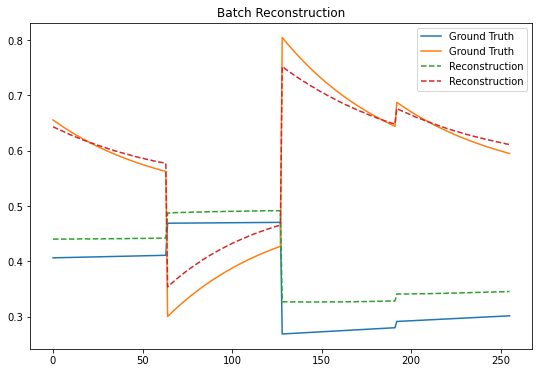

In [371]:
plt.title("Batch Reconstruction")
plt.rcParams['figure.figsize'] = [9, 6]
plt.plot(input, label = "Ground Truth")
plt.plot(out1, '--', label="Reconstruction")
plt.legend()

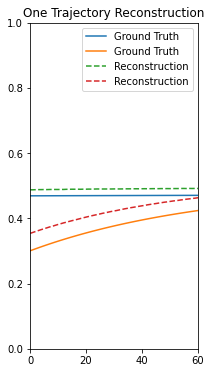

In [372]:
plt.figure(figsize=(3,6))
plt.plot(input[trajLength:trajLength*2], label = "Ground Truth")
plt.plot(out1[trajLength:trajLength*2], '--',label="Reconstruction")
plt.axis([0,60,0,1])
plt.title("One Trajectory Reconstruction")
plt.legend()

### Linear Prediction

In [373]:
x = input
x2 = []
for i in range(numTraj_batch):
    x2.append(x[i*trajLength+1:(i+1)*trajLength])
x2 = tf.reshape(x2, [-1, x.shape[-1]]) # Shifted input

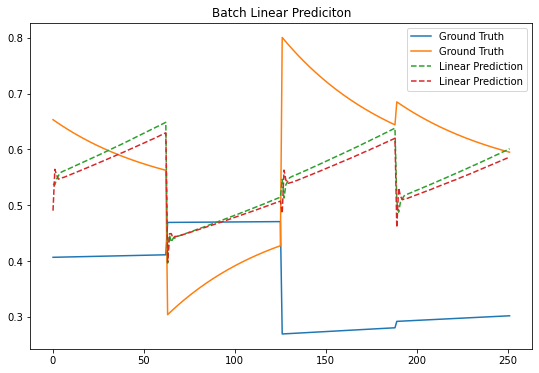

In [376]:
plt.title("Batch Linear Prediciton")
plt.rcParams['figure.figsize'] = [9, 6]
plt.plot(x2, label = "Ground Truth")
plt.plot(out3, '--', label="Linear Prediction")
plt.legend()

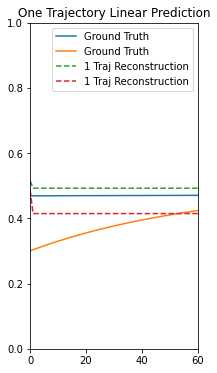

In [269]:
plt.figure(figsize=(3,6))
plt.plot(x[trajLength:trajLength*2], label = "Ground Truth")
plt.plot(out3[trajLength:trajLength*2], '--',label="1 Traj Reconstruction")
plt.axis([0,60,0,1])
plt.title("One Trajectory Linear Prediction")
plt.legend()

### Koopman Matrix

In [281]:
K = koopmanAEModel.koopman.get_weights()
print(K)

[array([[-0.00445435,  0.03486263,  0.05240768, ..., -0.09188695,
        -0.02962309,  0.0307944 ],
       [ 0.02796325,  0.0033116 , -0.01342553, ...,  0.08623408,
         0.06832797, -0.02954937],
       [ 0.00960039, -0.01033566,  0.05442968, ..., -0.02558011,
         0.03957865,  0.03539118],
       ...,
       [ 0.02060925,  0.07035584, -0.01843255, ..., -0.06754198,
         0.0338607 ,  0.03113608],
       [-0.00526544, -0.0098124 ,  0.03786495, ..., -0.02685338,
         0.0926961 , -0.08838371],
       [ 0.02594816, -0.06498678,  0.08850672, ..., -0.05961293,
        -0.08700536,  0.03354617]], dtype=float32)]


# Save the Model

In [282]:
koopmanAEModel.save('checkpoints/Trained_Model')

INFO:tensorflow:Assets written to: checkpoints/Trained_Model2\assets


# Load the Model

In [287]:
new_model = tf.keras.models.load_model('checkpoints/Trained_Model', compile=False)

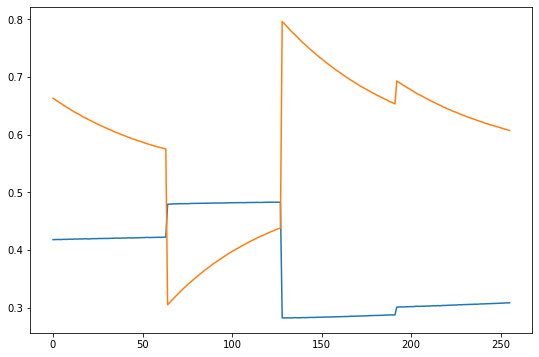

In [288]:
new_out1, new_out2, new_out3 = new_model(input)
plt.plot(new_out1)

In [ ]:
new_model.summary()

Model: "Koopman_AE_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_model_3 (EncoderMode multiple                  2704      
_________________________________________________________________
koopman__model_3 (Koopman_Mo multiple                  4096      
_________________________________________________________________
decoder_model_3 (DecoderMode multiple                  2642      
Total params: 9,442
Trainable params: 9,442
Non-trainable params: 0
_________________________________________________________________


In [ ]:
Z = new_model.enc(x_train)
K = new_model.koopman.get_weights()
K = np.squeeze(K)
print(K)


[[-1.4458780e-32 -2.1750893e-32 -3.3957881e-32 ...  1.4556152e-32
   3.2537463e-32 -6.7079844e-32]
 [-2.4723826e-32  9.8666317e-32 -9.9556660e-32 ... -1.3330958e-32
   5.4800277e-32  9.4859144e-32]
 [-6.1239685e-33 -4.9048727e-32  1.7167031e-32 ... -1.9827464e-32
  -8.0920802e-32 -9.6758226e-32]
 ...
 [-4.9446905e-32  1.1497769e-32  4.5361351e-32 ...  1.0229951e-31
  -3.1619346e-32  1.0109858e-31]
 [-1.0491194e-31 -3.1355507e-32 -8.2155847e-32 ... -2.6254396e-32
  -1.8558436e-32  8.8899111e-32]
 [-8.3344436e-32  1.4895980e-32  8.0287475e-32 ...  6.6009556e-32
   4.3219342e-32  5.3788905e-32]]
